# Deconstruct salt tank image - ChatGPT wrote this 

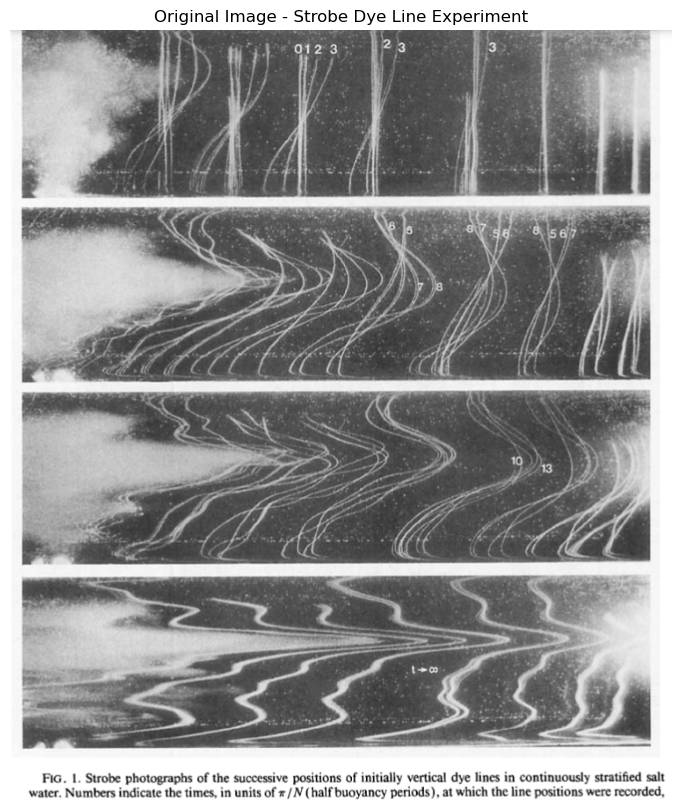

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# Load your image (update path if needed)
image_path = "Gregarious_salt_tank_photo.png"
original_img = Image.open(image_path).convert("L")  # Grayscale

# Show the image
plt.figure(figsize=(10, 10))
plt.imshow(original_img, cmap='gray')
plt.title("Original Image - Strobe Dye Line Experiment")
plt.axis("off")
plt.show()


In [3]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Settings
image_path = "Gregarious_salt_tank_photo.png"  # Your uploaded file
output_dir = "dye_line_outputs"
os.makedirs(output_dir, exist_ok=True)

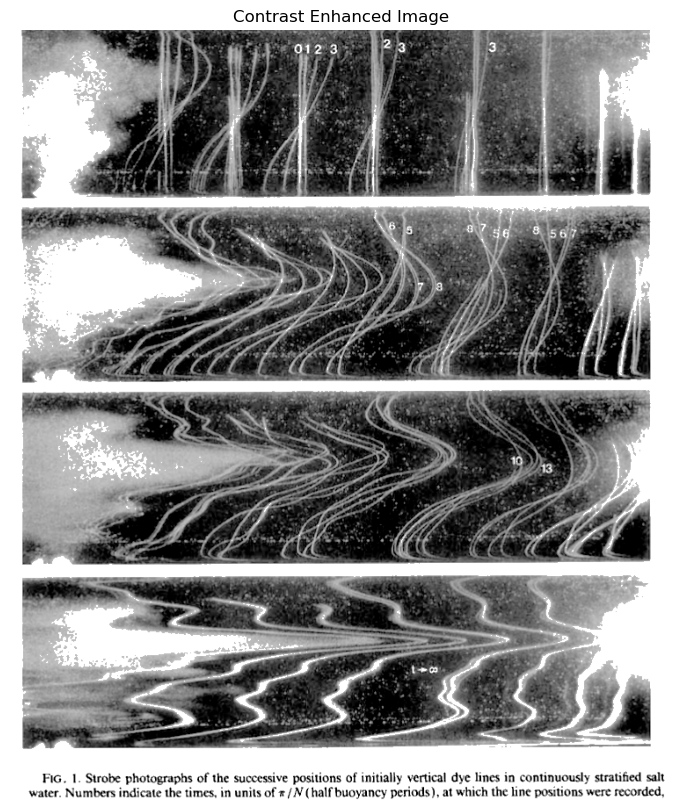

In [4]:
# Load grayscale
img = Image.open(image_path).convert("L")

# Enhance contrast slightly
enhancer = ImageEnhance.Contrast(img)
img_contrasted = enhancer.enhance(2.0)  # Play with value between 1.5–3.0 if needed

# Convert to array for OpenCV
img_array = np.array(img_contrasted)

# Optional: darken further via histogram equalization
img_eq = cv2.equalizeHist(img_array)

# Preview
plt.figure(figsize=(10, 10))
plt.imshow(img_eq, cmap='gray')
plt.title("Contrast Enhanced Image")
plt.axis('off')
plt.show()


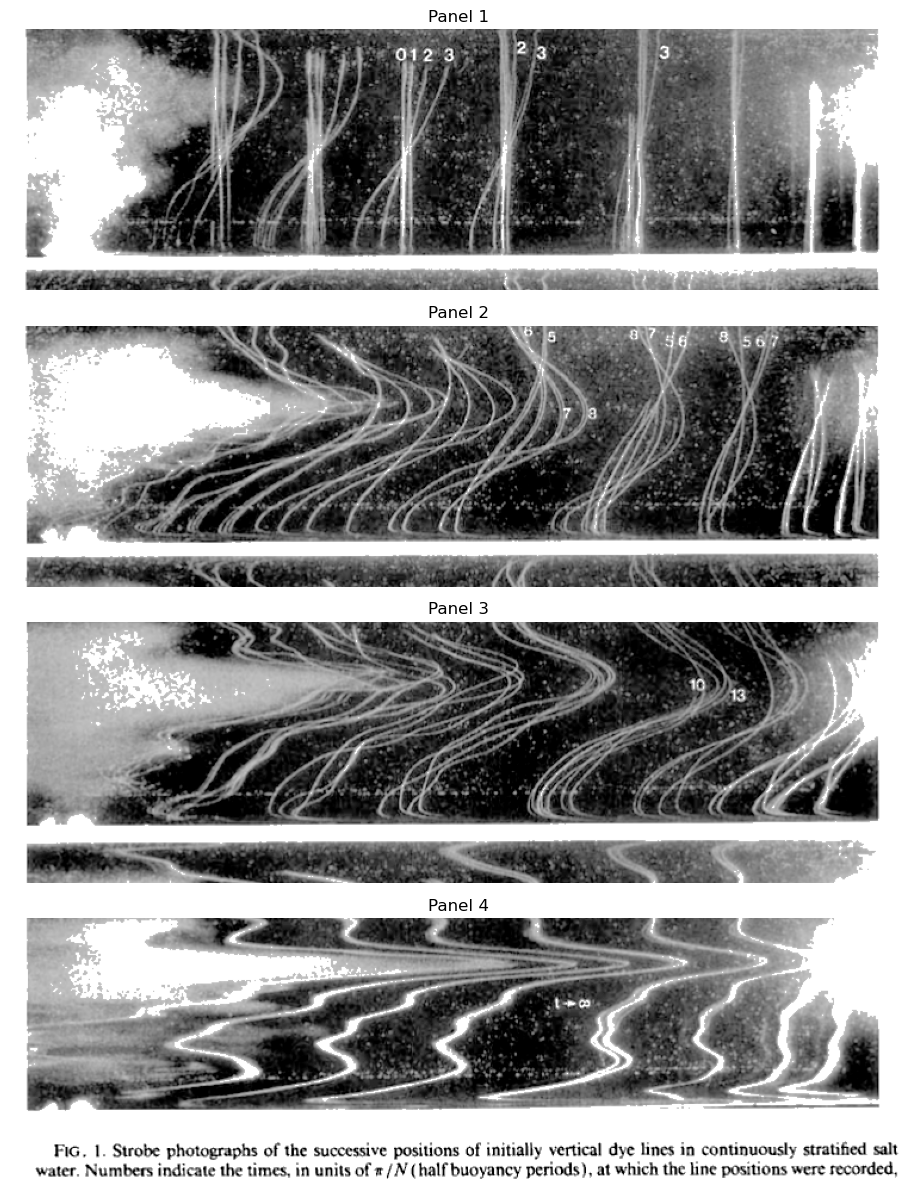

In [5]:
# Get height, split into 4 panels
h = img_eq.shape[0]
panel_height = h // 4
panels = [img_eq[i * panel_height:(i + 1) * panel_height, :] for i in range(4)]

# Preview each panel
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
for i, p in enumerate(panels):
    axs[i].imshow(p, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Panel {i + 1}')
plt.tight_layout()
plt.show()


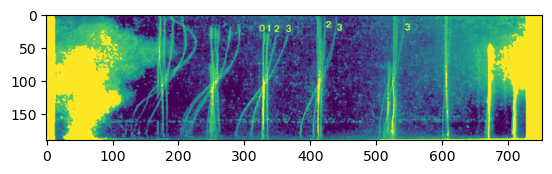

In [19]:
panel_1 = panels[0][0:190,:]
plt.imshow(panel_1)

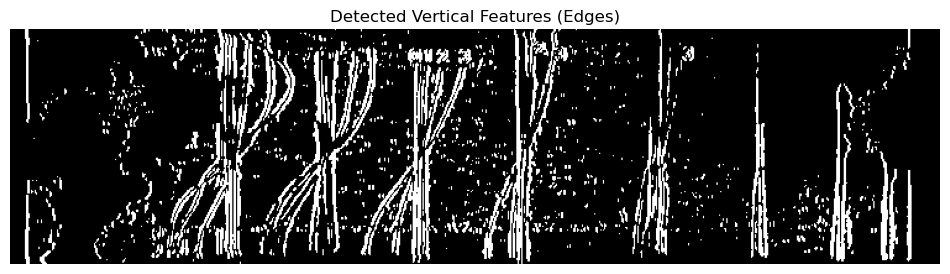

In [20]:
import cv2

# Use Sobel to detect vertical gradients
sobel_x = cv2.Sobel(panel_1, cv2.CV_64F, 1, 0, ksize=5)
sobel_x = np.abs(sobel_x)
sobel_x = (sobel_x / sobel_x.max() * 255).astype(np.uint8)

# Optional: threshold to isolate strong edges
_, thresh = cv2.threshold(sobel_x, 50, 255, cv2.THRESH_BINARY)

# Preview edges
plt.figure(figsize=(12, 5))
plt.imshow(thresh, cmap='gray')
plt.title("Detected Vertical Features (Edges)")
plt.axis('off')
plt.show()


In [23]:
# Define regions (approximate, based on visual inspection)
time_regions = {
    1: (60, 140),
    2: (140, 220),
    3: (220, 300),
}
colors = {
    1: [255, 0, 0],    # Red
    2: [0, 255, 0],    # Green
    3: [0, 0, 255],    # Blue
}


In [24]:
# Create color overlay image
overlay = np.zeros((panel_1.shape[0], panel_1.shape[1], 3), dtype=np.uint8)

for t, (x_start, x_end) in time_regions.items():
    # Extract region for this time
    region = thresh[:, x_start:x_end]
    
    # Create color mask
    color = colors[t]
    for c in range(3):
        overlay[:, x_start:x_end, c] += (region > 0) * color[c]

# Clip values just in case
overlay = np.clip(overlay, 0, 255)


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('int64') to dtype('uint8') with casting rule 'same_kind'

In [21]:
# Convert grayscale panel to 3-channel
panel_rgb = np.stack([panel_1]*3, axis=-1)

# Blend: use mask where overlay is nonzero
alpha = 0.7  # color overlay strength
mask = np.any(overlay > 0, axis=-1, keepdims=True)
blended = np.where(mask, alpha * overlay + (1 - alpha) * panel_rgb, panel_rgb).astype(np.uint8)

# Preview
plt.figure(figsize=(12, 6))
plt.imshow(blended)
plt.title("Colorized Line Features at t=1 (red), t=2 (green), t=3 (blue)")
plt.axis('off')
plt.show()


NameError: name 'overlay' is not defined

In [6]:
# Define rough x ranges (you may need to fine-tune these)
# Format: (panel_index, x_start, x_end, time_label)
time_ranges = [
    (0, 40, 90, 0), (0, 90, 130, 1), (0, 130, 170, 2), (0, 170, 210, 3),
    (1, 70, 130, 5), (1, 130, 180, 6), (1, 180, 230, 7), (1, 230, 270, 8),
    (2, 70, 130, 10), (2, 130, 190, 13),
    (3, 60, 310, 14),  # "infinity" line
]

# Use time_label=14 for t=∞


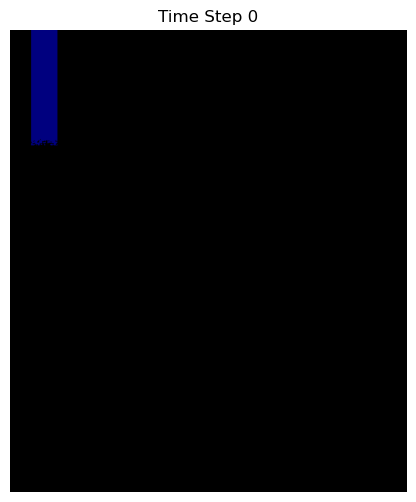

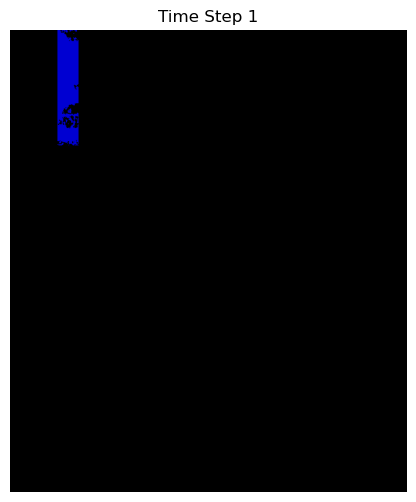

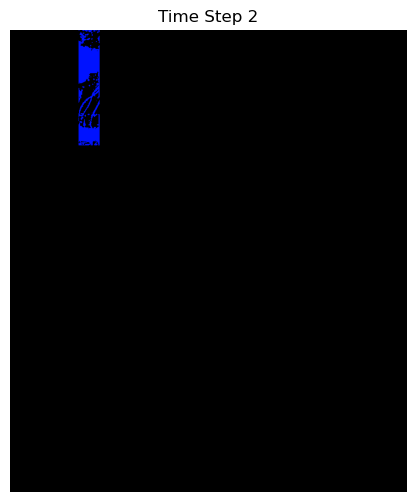

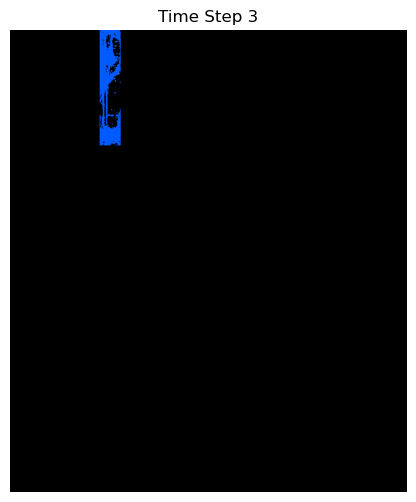

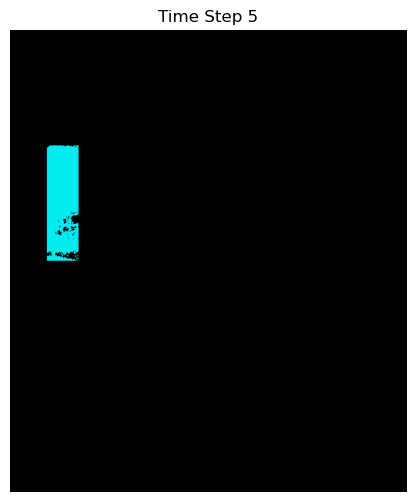

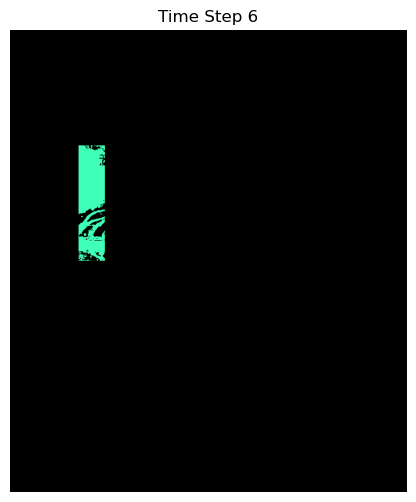

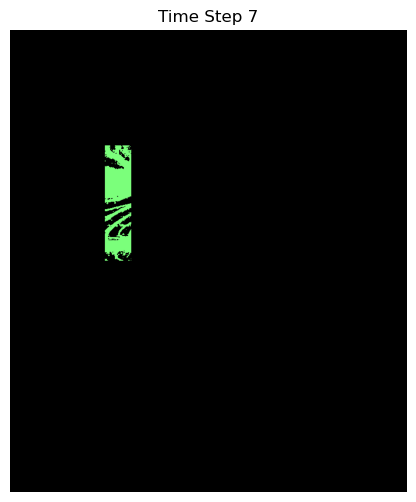

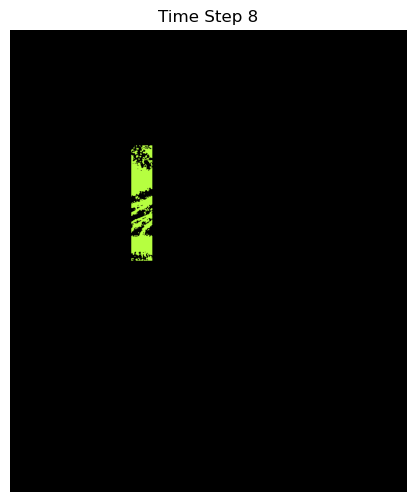

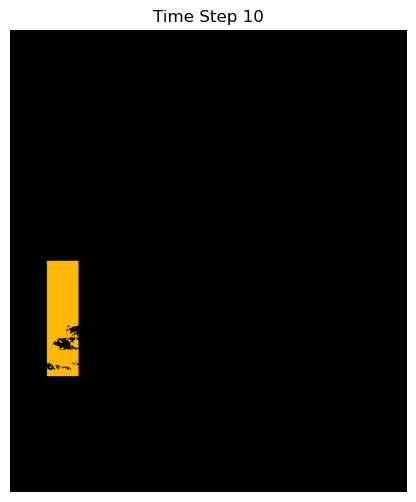

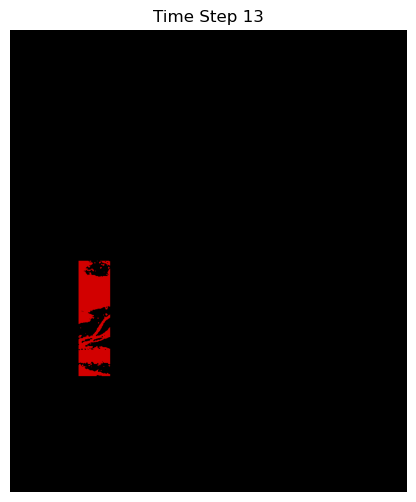

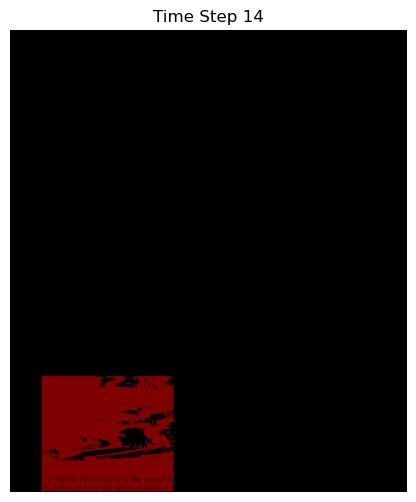

In [7]:
# Colormap for 15 time steps (0–14)
cmap = plt.get_cmap("jet", 15)

for panel_idx, x_start, x_end, time_label in time_ranges:
    # Extract from panel
    sub_img = panels[panel_idx][:, x_start:x_end]

    # Normalize to 0–1
    norm_img = cv2.normalize(sub_img, None, 0, 255, cv2.NORM_MINMAX)
    
    # Threshold to isolate lines (optional tweak threshold)
    _, binary = cv2.threshold(norm_img, 50, 255, cv2.THRESH_BINARY)

    # Create a color image
    color_img = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)
    color = np.array(cmap(time_label)[:3]) * 255  # RGB from colormap

    color_img[binary > 0] = color.astype(np.uint8)

    # Paste into full-frame image
    full_color_img = np.zeros((img_eq.shape[0], img_eq.shape[1], 3), dtype=np.uint8)
    y_offset = panel_idx * panel_height
    full_color_img[y_offset:y_offset + binary.shape[0], x_start:x_end] = color_img

    # Optional: darken background to black
    mask = np.any(full_color_img > 0, axis=-1)
    full_color_img[~mask] = [0, 0, 0]

    # Save and preview
    output_path = os.path.join(output_dir, f"time_{time_label:02d}.png")
    Image.fromarray(full_color_img).save(output_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(full_color_img)
    plt.title(f"Time Step {time_label}")
    plt.axis('off')
    plt.show()
